## Training curves

100


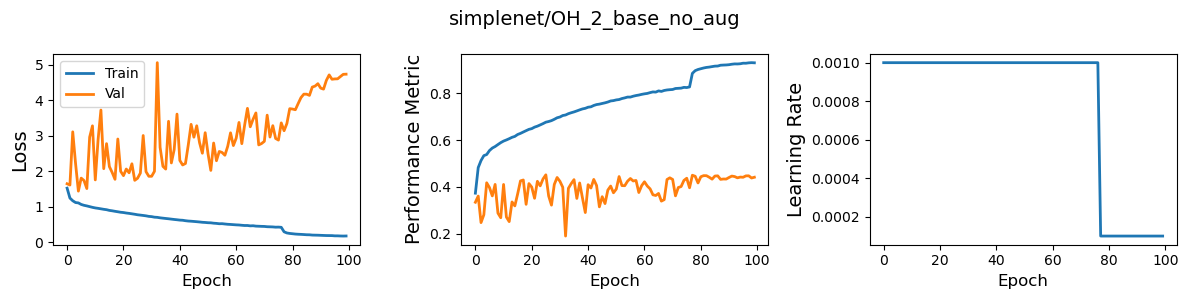

In [1]:
from plotting import plot_training_curve
import pathlib

# load in trained weights
arch_type='simplenet'
model_name = 'OH_2_base_no_aug'

results_dir = pathlib.Path('/qfs/projects/thidwick/weights/manga/')
model_weights_dir = results_dir / arch_type / model_name

plot_training_curve(model_weights_dir, log=False)

## Datacube Evaluation

In [2]:
import sys
import torch
import numpy as np
import pathlib
import logging
import sys
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

from utils import plateid_to_fits_file
from eval_utils import(
    datacube_evaluator
)
from comparison_fns import visualize_gal_labels

data_dir = pathlib.Path('/gscratch/scrubbed/mmckay18/DATA/')
results_dir = pathlib.Path('/gscratch/astro/mmckay18/DATA/weights/')

RuntimeError: No CUDA GPUs are available

INFO:root:Using CLASSIFICATION presents
INFO:root:Found 2660 npy files in /raid/byle431/manga/processed/patches/logOH/global/11978-12703
INFO:root:Loading SimpleNet
INFO:root:Running AllPredictions


collecting predictions:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:root:Running in DATACUBE mode


collecting predictions: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


---- 11978-12703 ------
Accuracy: 0.568
Acc (Top2): 0.825
IOU: 0.396

INFO:root:Using CLASSIFICATION presents
INFO:root:Found 2736 npy files in /raid/byle431/manga/processed/patches/logOH/global/11975-12705
INFO:root:Loading SimpleNet
INFO:root:Running AllPredictions


collecting predictions:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:root:Running in DATACUBE mode


collecting predictions: 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]


---- 11975-12705 ------
Accuracy: 0.572
Acc (Top2): 0.841
IOU: 0.400



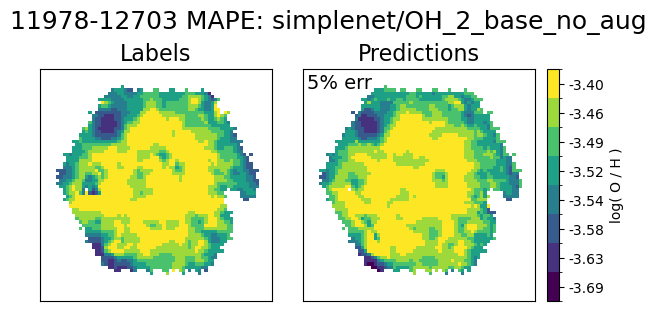

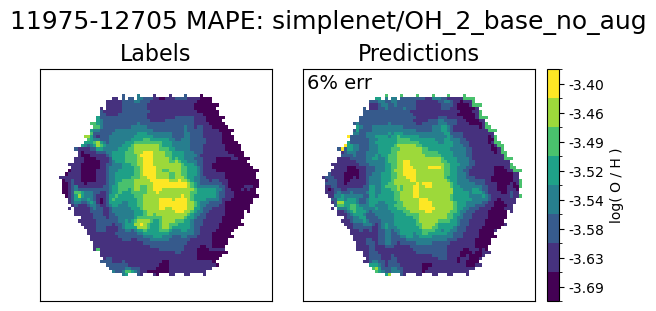

In [2]:
device = torch.device('cuda:0')

arch_type = 'simplenet'
OH_key='extra'
model_name = 'OH_2_base_no_aug'
metric = 'MAPE'

list_of_ids = ['11978-12703', '11975-12705']

for plate_id in list_of_ids:
    fits_file = plateid_to_fits_file(plate_id)
    # output is a dictionary with predictions and ground truth labels
    output = datacube_evaluator(
        fits_file,
        arch_type=arch_type, 
        model_weights_dir=results_dir / arch_type / model_name,
        OH_key=OH_key,
        device=device,
        num_workers=4,
    )
    print(f'---- {plate_id} ------')
    print(f"Accuracy: {output['accuracy']:.3f}")
    print(f"Acc (Top2): {output['Top2Accuracy']:.3f}") 
    print(f"IOU: {output['IOU']:.3f}\n")
    # make figure -----------
    visualize_gal_labels(
        plate_id, 
        output, 
        title=f'{plate_id} {metric}: {arch_type}/{model_name}',
        OH_key=OH_key, 
        metric=metric,
        save_fig=True,
        OH_log=True,
        output_path=f'./figs/{model_name}/{arch_type}_{metric}_{plate_id}.png',
        cb_label='log( O / H )'
    )

In [3]:
output.keys()

dict_keys(['predictions', 'labels', 'map_index', 'CM', 'ClasswiseAccuracy', 'ClasswiseIOU', 'IOU', 'Top2Accuracy', 'accuracy', 'MAE', 'MAPE', 'MSE', 'label_map', 'pred_map', 'correct_mask'])

# Evaluating full test data set

In [8]:
import torch
from convenience import quick_eval

---- simplenet / OH_2_base_no_aug ----------
INFO:root:Using OH_key: extra
INFO:root:Loading SimpleNet


collecting predictions: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


	Accuracy: 44.6%
	MAPE:      8.0%


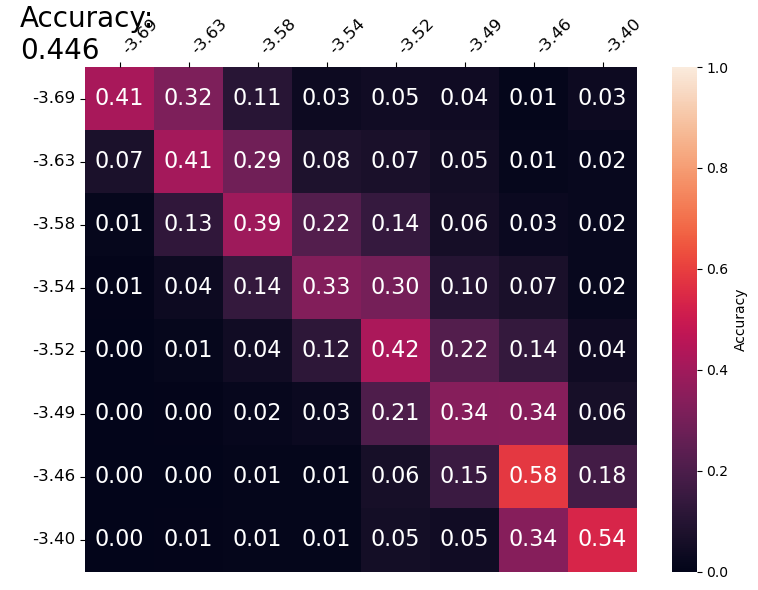

In [10]:
device = torch.device('cuda:0')

arch_type = 'simplenet'
model_suff = 'base_no_aug'
split_dir='OH_2'
OH_key='extra'

quick_eval(
    arch_type=arch_type,
    model_suff=model_suff,
    split_dir=split_dir,
    OH_key=OH_key,
    device=device,
)

### read from pickle file

	Accuracy: 70.0%
	MAPE:  8.0%


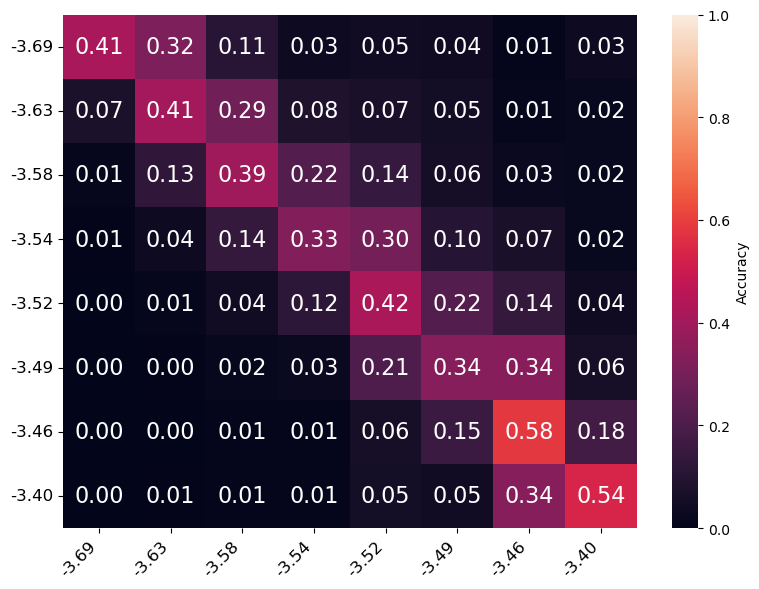

In [11]:
import pickle
from utils import get_index_to_name
from plotting import plot_tm_confusion_matrix

results_dir = pathlib.Path('/qfs/projects/thidwick/weights/manga/')
OH_key='extra'
arch_type='simplenet'
model_name = 'OH_2_base_no_aug'
output_file = results_dir / arch_type / model_name / 'test_split_metrics.pkl'

# --- read in previously computed stats ------------
with open(output_file, 'rb') as f:
    out = pickle.load(f)

# print stats and plot confusion matrix ------------
print(f'\tAccuracy: {out["DL"]["Top2Accuracy"]*100.0: >4.1f}%')
print(f'\tMAPE: {out["DL"]["MAPE"]*100.0: >4.1f}%')

index_to_name = get_index_to_name(OH_key, log=True)
class_list = [index_to_name[i] for i in range(len(index_to_name))]
fig = plot_tm_confusion_matrix(
    out['DL']['CM'],
    class_list=class_list,
    normalized=True,
    title=None,
    annotate_accuracy=False,
    save_figure=True,
    fontsize=12,
    output_path=f'./figs/confusion/test_{model_name}.png',
    top_x=False
)